Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

---

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Author: Sebastian Raschka

Python implementation: CPython
Python version       : 3.8.8
IPython version      : 7.21.0

torch: 1.8.1+cu111



# MobileNet-v2 trained on Cifar-10

## Imports

In [2]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
sys.path.insert(0, "..") # to include ../helper_evaluate.py etc.

# From local helper files
from helper_utils import set_all_seeds, set_deterministic
from helper_evaluate import compute_confusion_matrix, compute_accuracy
from helper_train import train_classifier_simple_v2
from helper_plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helper_data import get_dataloaders_cifar10, UnNormalize

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

RANDOM_SEED = 123
BATCH_SIZE = 128
NUM_EPOCHS = 150
DEVICE = torch.device('cuda:3' if torch.cuda.is_available() else 'cpu')

In [5]:
set_all_seeds(RANDOM_SEED)
#set_deterministic()

In [6]:
##########################
### CIFAR-10 DATASET
##########################

### Note: Network trains about 2-3x faster if you don't
# resize (keeping the orig. 32x32 res.)
# Test acc. I got via the 32x32 was lower though; ~77%

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),        
    torchvision.transforms.CenterCrop((64, 64)),            
    torchvision.transforms.ToTensor(),                
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


train_loader, valid_loader, test_loader = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms,
    test_transforms=test_transforms,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

Files already downloaded and verified
Image batch dimensions: torch.Size([128, 3, 64, 64])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])


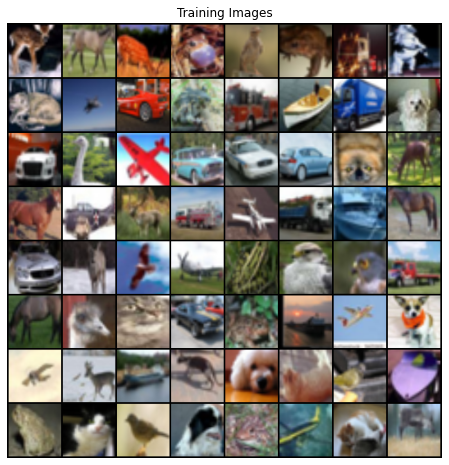

In [7]:
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(torchvision.utils.make_grid(images[:64], 
                                         padding=2, normalize=True),
                        (1, 2, 0)))

## Model

In [8]:
##########################
### MODEL
##########################


model = torch.hub.load('pytorch/vision:v0.9.0', 'mobilenet_v2',
                       pretrained=False)

model.classifier[-1] = torch.nn.Linear(in_features=1280, # as in original
                                       out_features=10) # number of class labels in Cifar-10)

model = model.to(DEVICE)

Using cache found in /home/raschka/.cache/torch/hub/pytorch_vision_v0.9.0


Epoch: 001/150 | Batch 0000/0351 | Loss: 2.3627
Epoch: 001/150 | Batch 0100/0351 | Loss: 1.9649
Epoch: 001/150 | Batch 0200/0351 | Loss: 1.7862
Epoch: 001/150 | Batch 0300/0351 | Loss: 1.9222
Epoch: 001/150 | Train: 32.20% | Validation: 32.60% | Best Validation (Ep. 001): 32.60%
Time elapsed: 0.99 min
Epoch: 002/150 | Batch 0000/0351 | Loss: 1.9170
Epoch: 002/150 | Batch 0100/0351 | Loss: 1.7127
Epoch: 002/150 | Batch 0200/0351 | Loss: 1.8019
Epoch: 002/150 | Batch 0300/0351 | Loss: 1.6782
Epoch: 002/150 | Train: 34.07% | Validation: 33.52% | Best Validation (Ep. 002): 33.52%
Time elapsed: 2.00 min
Epoch: 003/150 | Batch 0000/0351 | Loss: 1.7150
Epoch: 003/150 | Batch 0100/0351 | Loss: 1.6087
Epoch: 003/150 | Batch 0200/0351 | Loss: 1.4612
Epoch: 003/150 | Batch 0300/0351 | Loss: 1.5310
Epoch: 003/150 | Train: 44.74% | Validation: 45.50% | Best Validation (Ep. 003): 45.50%
Time elapsed: 2.99 min
Epoch: 004/150 | Batch 0000/0351 | Loss: 1.4913
Epoch: 004/150 | Batch 0100/0351 | Loss: 1.

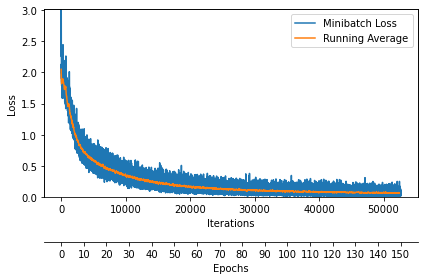

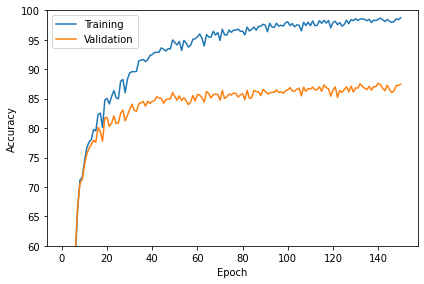

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

minibatch_loss_list, train_acc_list, valid_acc_list = train_classifier_simple_v2(
    model=model,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    best_model_save_path='mobilenet-v2-best-1.pt',
    device=DEVICE,
    scheduler_on='valid_acc',
    logging_interval=100)


plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=200)
plt.show()

plot_accuracy(train_acc_list=train_acc_list,
              valid_acc_list=valid_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

In [10]:
model.load_state_dict(torch.load('mobilenet-v2-best-1.pt'))
model.eval()
test_acc = compute_accuracy(model, test_loader, device=DEVICE)
print(f'Test accuracy: {test_acc:.2f}%')

Test accuracy: 86.66%


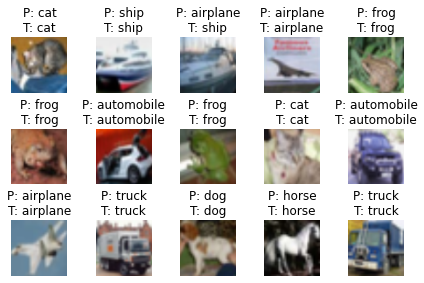

In [11]:
model.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model, data_loader=test_loader, unnormalizer=unnormalizer, class_dict=class_dict)

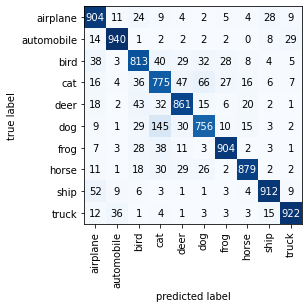

In [12]:
mat = compute_confusion_matrix(model=model, data_loader=test_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()